## **1. Import Libraries and Dataset**

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  print(gpu)
  tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4R2WYR/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4R2WYR/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## **2. Visualize Data**

In [5]:
import numpy as np

In [6]:
# Setup connection (iterator)
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()

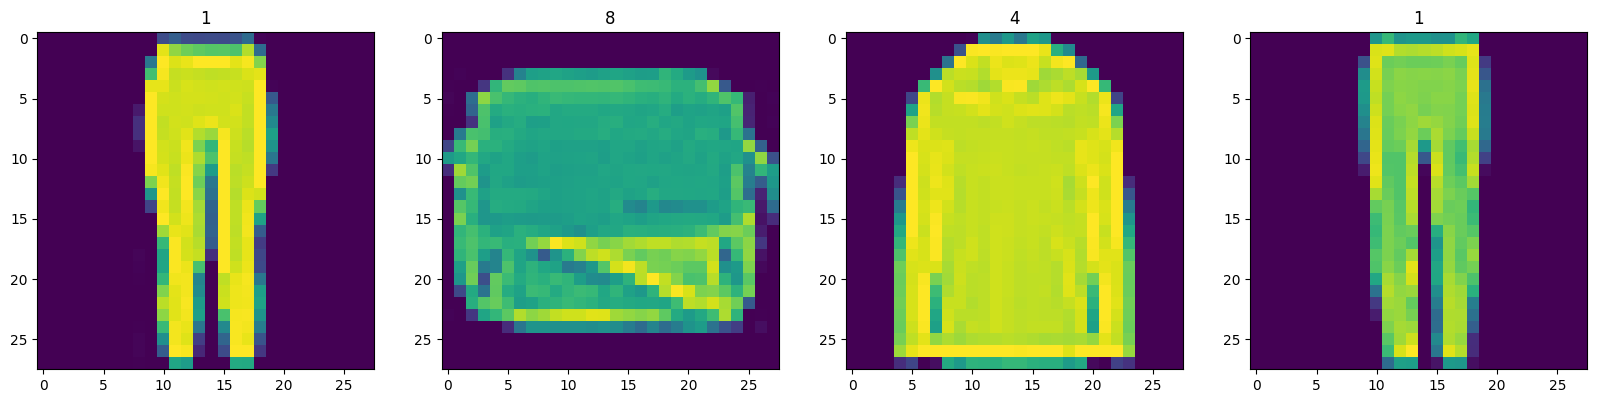

In [8]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [9]:
# Scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [10]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_image preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch in 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## **3. Build the Neural Networks**

In [12]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the NN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [13]:
def build_generator():
  model = Sequential()

  # Beginning of a generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsamplig block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsamplig block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [14]:
generator = build_generator()

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [22]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 19ms/step


In [ ]:
img.shape

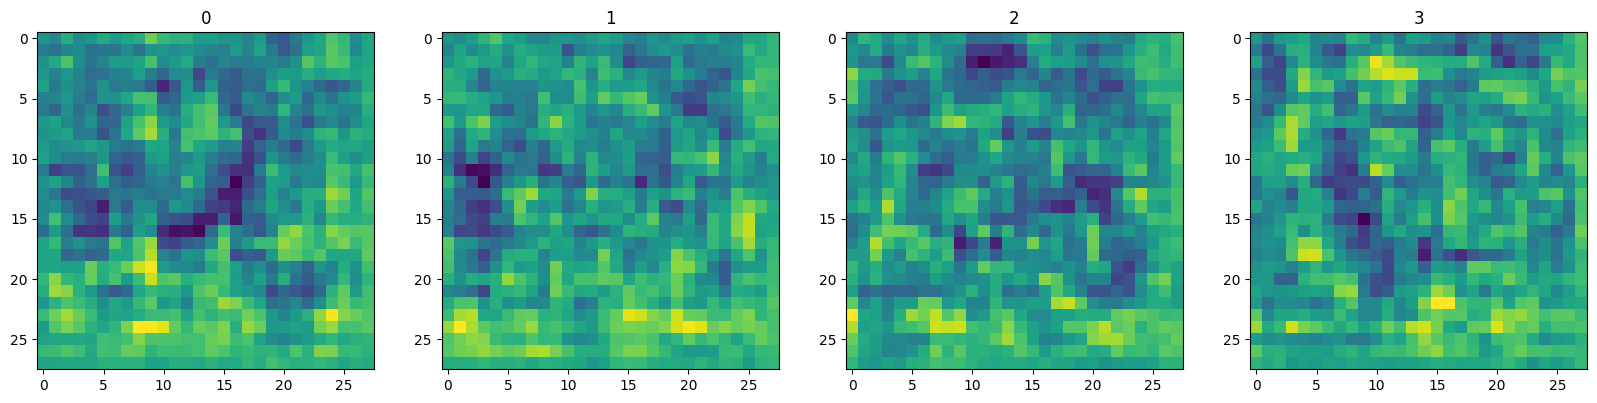

In [17]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [18]:
def build_discriminator():
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv Block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third Conv Block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [19]:
discriminator = build_discriminator()

In [20]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [23]:
discriminator.predict(img)

1/1 [==============================] - 0s 471ms/step


array([[0.49602312],
       [0.49628577],
       [0.49597526],
       [0.49610743]], dtype=float32)

## **4. Construct Training Loop**

### 4.1 Setup Losses and Optimizers

In [24]:
# Adam is going to be te optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [25]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 4.2 Build Subclassed Model

In [26]:
from tensorflow.keras.models import Model

In [27]:
class FashionGAN(Model):

  def __init__(self, generator, discriminator, *args, **kwargs):
    # Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    # Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_otp, d_opt, g_loss, d_loss, *args, **kwargs):
    # Compile with base class
    super().compile(*args, **kwargs)

    # Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128, 1)), training= False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for real and fakes images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculate loss -  BINARYCROSS
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate loss - faking out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [28]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [29]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build Callback

In [30]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## 4.4 Train

In [32]:
# Reccomend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 92s 167ms/step - d_loss: 0.5694 - g_loss: 0.8478
Epoch 2/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.3537 - g_loss: 5.2585
Epoch 3/20
469/469 [==============================] - 81s 173ms/step - d_loss: 0.3717 - g_loss: 5.4573
Epoch 4/20
469/469 [==============================] - 80s 170ms/step - d_loss: 0.6889 - g_loss: 0.6806
Epoch 5/20
469/469 [==============================] - 80s 170ms/step - d_loss: 0.6992 - g_loss: 0.5955
Epoch 6/20
469/469 [==============================] - 81s 174ms/step - d_loss: 0.7014 - g_loss: 0.6259
Epoch 7/20
469/469 [==============================] - 80s 171ms/step - d_loss: 0.6947 - g_loss: 0.6596
Epoch 8/20
469/469 [==============================] - 80s 170ms/step - d_loss: 0.6954 - g_loss: 0.6623
Epoch 9/20
469/469 [==============================] - 80s 171ms/step - d_loss: 0.6537 - g_loss: 0.7495
Epoch 10/20
469/469 [==============================] - 79s 168ms/step - d

## 4.4 Review Performance

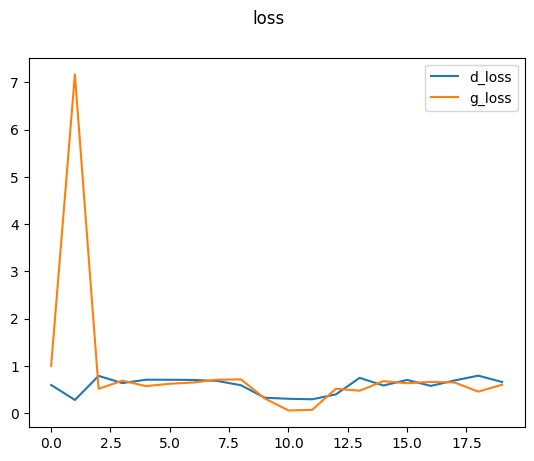

In [33]:
plt.suptitle('loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# **5. Test out the generator**

In [37]:
generator.load_weights(os.path.join('.', 'generator.h5'))

In [38]:
imgs = generator.predict(tf.random.normal((16,128, 1)))

1/1 [==============================] - 0s 464ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

# **6. Saving the model**

In [35]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
